<a href="https://colab.research.google.com/github/whyzhuce/XConparraison/blob/master/Local_vol_PDE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Volatilité locale (Dupire) : PDE
---

> **Antonin Chaix**

Le but de ce TP est de reprendre la calibration de la volatilité locale implémentée dans [ce Colab](https://colab.research.google.com/drive/1Jc0EUawS9uXigJ7A4er1joMr-8eJH80W?usp=sharing) (vol implicite de marché donnée par le modèle SABR avec une term structure de paramètres SABR interpolée en temps par des splines cubiques), et de mettre en place dans ce modèle un schéma de différence finies, qui va permettre d'évaluer de nombreuses options bien plus rapidement et plus précisément qu'en Monte Carlo.

## Market datas et calcul de la volatilité locale

On reprend donc à l'identique de [ce TP](https://colab.research.google.com/drive/1Jc0EUawS9uXigJ7A4er1joMr-8eJH80W?usp=sharing) les market datas (courbe des taux, forwards, nappe de vol implicite), ainsi que le calcul de la volatilité locale via la formule de Dupire.

In [ ]:
import numpy as np
import math
from scipy.interpolate import interp1d
from scipy.stats import norm

# yield curve (zero rates)
yc_maturities = np.array([0, 1, 2, 5, 10, 15, 20, 30])
yc_zc_rates = np.array([-0.55, -0.52, -0.51, -0.4,  -0.18,  0.02,  0.11,  0.09]) * 0.01
yc_zc_rates_interp = interp1d(yc_maturities, yc_zc_rates, kind='cubic', fill_value="extrapolate")

def zc_rate(T) :
    return yc_zc_rates_interp(T)

def DF(T) :
    return np.exp(-yc_zc_rates_interp(T)*T)

# underlying params
S0 = 100
S_maturities = np.array([0.08, 0.25, 0.50, 1.00, 1.50, 2.00])
S_forwards = np.array([99.9563, 99.8655, 99.7354, 99.4813, 99.2301, 98.9851])  # généré sans dividendes avec s_forwards = S0 * np.exp(zc_rate(s_maturities)*s_maturities)
S_sigma0 = np.array([20.0, 18.5, 17.4, 16.5, 15.5, 14.5]) * 0.01
S_alpha = np.array([95, 80, 70, 60, 50, 40]) * 0.01
S_rho = np.array([-0.4, -0.35, -0.3, -0.3, -0.3, -0.3])
S_beta = np.full(6, 1.)

# implied vol : cubic spline interp on sabr params
S_forwards_interp = interp1d(S_maturities, S_forwards, kind='cubic', fill_value="extrapolate")
S_sigma0_interp = interp1d(S_maturities, S_sigma0, kind='cubic', fill_value="extrapolate")
S_alpha_interp = interp1d(S_maturities, S_alpha, kind='cubic', fill_value="extrapolate")
S_rho_interp = interp1d(S_maturities, S_rho, kind='cubic', fill_value="extrapolate")
S_beta_interp = interp1d(S_maturities, S_beta, kind='cubic', fill_value="extrapolate")

# BS call function
def bs_call(T, K, F0, sigma) :
    sigma_sqrt_T = sigma * math.sqrt(T)
    d1 = (math.log(F0/K) + 0.5 * sigma**2 * T) / sigma_sqrt_T
    d2 = d1 - sigma_sqrt_T
    return F0 * norm.cdf(d1) - K * norm.cdf(d2)

# SABR lognormal vol formula from [https://github.com/ynouri/pysabr] made numpy compatible
def sabr_vol (T, K, F0, sigma0, alpha, rho, beta) :
    """
    Hagan's 2002 SABR lognormal vol expansion.
    The strike K can be a scalar or an array, the function will return an array
    of lognormal vols.
    """
    eps = 1e-07
    logfk = np.log(F0 / K)
    fkbeta = (F0*K)**(1 - beta)
    a = (1 - beta)**2 * sigma0**2 / (24 * fkbeta)
    b = 0.25 * rho * beta * alpha * sigma0 / fkbeta**0.5
    c = (2 - 3*rho**2) * alpha**2 / 24
    d = fkbeta**0.5
    v = (1 - beta)**2 * logfk**2 / 24
    w = (1 - beta)**4 * logfk**4 / 1920
    z = alpha * fkbeta**0.5 * logfk / sigma0
    tmp = sigma0 * (1 + (a + b + c) * T)
    num = np.where(abs(z) > eps, z * tmp, tmp)
    den = np.where(abs(z) > eps, (d * (1 + v + w) * _x(rho, z)), d * (1 + v + w))
    return num / den

def _x(rho, z):
    """Return function x used in Hagan's 2002 SABR lognormal vol expansion."""
    a = (1 - 2*rho*z + z**2)**.5 + z - rho
    b = 1 - rho
    return np.log(a / b)

# implied vol : time dependent spline interpolation of SABR parameters
def implied_vol(T, K) :
    F0 = S_forwards_interp(T)
    sigma0 = S_sigma0_interp(T)
    alpha = S_alpha_interp(T)
    rho = S_rho_interp(T)
    beta = S_beta_interp(T)
    return sabr_vol(T, K, F0, sigma0, alpha, rho, beta)

# local vol from Dupire's formula
def local_vol(t, S) :
    t = np.where(t == 0, 1e-08, t) # to avoid divide by 0
    eps_t = 1e-07
    eps_S = eps_t * S
    vol = implied_vol(t, S)
    sqrt_t = np.sqrt(t)
    drift = np.log(S_forwards_interp(t + eps_t) / S_forwards_interp(t)) / eps_t
    dvol_dT = (implied_vol(t + eps_t, S) - vol) / eps_t
    dvol_dK = (implied_vol(t, S + eps_S) - vol) / eps_S
    d2vol_dK2 = (implied_vol(t, S + eps_S) + implied_vol(t, S - eps_S) - 2 * vol ) / eps_S**2
    d1 = (np.log(S0 / S) + np.log(S_forwards_interp(t) / S0) + 0.5 * vol**2 * t) / (vol * sqrt_t)
    num = 2 * dvol_dT + vol / t + 2 * S * drift * dvol_dK
    den = S**2 * (d2vol_dK2 - d1*sqrt_t*dvol_dK**2 + (1/(S*sqrt_t) + d1*dvol_dK)**2 / vol)
    return np.sqrt(np.where(num/den >= 0, num/den, 0))

## Equation aux dérivées partielles satisfaite par un prix d'option

Rappelons l'EDS du modèle, sous la mesure risque-neutre :

$$
\frac{dS_t}{S_t}=\mu(t)dt+\sigma(t,S_t)dW_t
$$

c'est à dire :
$$
dS_t=\mu(t)S_tdt+\sigma(t,S_t)S_tdW_t
$$

où le drift déterministe $\mu(t)$ est inféré à partir de la term-structure des forwards sur l'actif $S$ via la relation :

$$
F_0(T) = S_0\exp\left(\int_0^T \mu(s)ds\right), \quad \forall T
$$

On chercher a évaluer une option dont on notera $v(t,S_t)$ la valeur à la date $t$ et pour le niveau de spot $S_t$.

L'équation au dérivées partielle (EDP, ou PDE en anglais) s'obtient en appliquant le lemme d'Ito à la fonction $v$ :

$$
dv(t,S_t) = \frac{\partial v}{\partial t}(t,S_t)dt + \frac{\partial v}{\partial s}(t,S_t)dS_t + \frac{1}{2}\frac{\partial^2 v}{\partial s^2}(t,S_t)\sigma(t,S_t)^2 S_t^2 dt
$$

En remplaçant $dS_t$ par son expression dans le modèle à vol locale on obtient :

$$
dv(t,S_t) =\left( \frac{\partial v}{\partial t}(t,S_t) + \mu(t)S_t\frac{\partial v}{\partial s}(t,S_t) + \frac{1}{2}\sigma(t,S_t)^2 S_t^2\frac{\partial^2 v}{\partial s^2}(t,S_t)\right)dt + \sigma(t,S_t)S_t\frac{\partial v}{\partial s}(t,S_t)dW_t
$$

Par ailleurs, l'option de valeur $v$ est un actif et a donc pour drift le taux (court) sans risque $r(t)$, inféré à partir de la courbe des taux :

$$
dv(t,S_t) = r(t)v(t,S_t)dt +(\dots)dW_t
$$

La valeur d'un discount factor de maturité $T$ se calcule comme $B_0(T)=\exp(-\int_0^t r(t)dt)$, si bien que le taux court peut être obtenu à partir de la courbe zéro-coupon de la façon suivante :

$$
r(t) = -\frac{d\ln B_0}{dT}(t)
$$

En identifiant les deux expressions obtenues pour le drift du processus $v(t,S_t)$ on aboutit à l'EDP suivante :

$$
\frac{\partial v}{\partial t}(t,S_t) + \mu(t)S_t\frac{\partial v}{\partial s}(t,S_t) + \frac{1}{2}\sigma(t,S_t)^2 S_t^2\frac{\partial^2 v}{\partial s^2}(t,S_t) - r(t)v(t,S_t) = 0
$$

C'est à dire, écrit de façon plus compacte :

$$
\frac{\partial v}{\partial t} + \mu(t)s\frac{\partial v}{\partial s} + \frac{1}{2}\sigma(t,s)^2 s^2\frac{\partial^2 v}{\partial s^2} - r(t)v = 0
$$

## Schéma de différences finies

L'idée du schéma de différences finies est de discrétiser l'EDP précédente en temps et en espace, pour la résoudre *backward*, en partant de $T$ avec une condition limite dépendant de l'option (par exemple $v(T,s)=(s-K)^+$ pour un call européen) puis en rétropropageant l'équation jusqu'en $t=0$.


On utilise une grille temps/espace $(t_i)\times(s_i)$. Dans ce qui suit, si $s=s_i$,  $s^+$ doit être compris comme $s_{i+1}$ et $s^-$ comme $s_{i-1}$. De manière analogue, si $t=t_j$, $t^+$ correspond à la date $t_{j+1}$.

Les opérateurs de dérivation discrets dans la dimension espace sont:

$$
D_1 v(t,s)= \frac{v(t,s^+)-v(t,s^-)}{s^+-s^-}\approx \frac{\partial v}{\partial s}(t,s)
$$

et

$$
D_2 v(t,s)=
\frac{\frac{v(t,s^+)-v(t,s)}{s^+-s}-\frac{v(t,s)-v(t,s^-)}{s-s^-}}{\frac{s^+ + s}{2}-\frac{s + s^-}{2}}=
2\left\{\frac{v(t,s^+)-v(t,s)}{(s^+-s^-)(s^+-s)}-\frac{v(t,s)-v(t,s^-)}{(s^+-s^-)(s-s^-)}\right\}\approx \frac{\partial^2 v}{\partial s^2}(t,s)
$$

Supprimons la dérivée en temps $\partial v/\partial t$ de l'EDP et discrétisons la partie restante de la façon suivante (le terme entre crochet pouvant se résumer par un opérateur $A$ appliqué à $v$):

$$
\mu(t)s\frac{\partial v}{\partial s}(t,s) + \frac{1}{2}\sigma(t,s)^2 s^2\frac{\partial^2 v}{\partial s^2}(t,s) - r(t)v(t,s) \approx \frac{1}{t^+-t}\left[\bar\mu(t)sD_1v(t,s)+\frac{1}{2}\sigma(t,s)^2s^2(t^+-t)D_2v(t,s)-\bar r(t,s)v(t,s)\right] =\frac{1}{t^+-t}Av(t,s)
$$

avec :
$$
\bar\mu(t) = \int_t^{t^+}\mu(u)du = \ln\left(\frac{F_0(t^+)}{F_0(t)}\right)\qquad\bar r(t)=\int_t^{t^+}r(u)du=\ln\left(\frac{B_0(t^+)}{B_0(t)}\right)
$$

Si bien que la version discrétisée de l'EDP s'obtient comme :

$$
\frac{v(t^+,s) - v(t,s)}{t^+-t} + \frac{1}{t^+-t}Av(t,s) = 0
$$

c'est à dire tout simplement :

$$
v(t^+,s) - v(t,s) + Av(t,s) = 0
$$

Ce schéma est dit *implicite*. Connaissant les valeur de $v$ pour tous les $s$ à la date $t^+$, il faut inverser une matrice (tridiagonale) pour obtenir les valeurs de $v$ à la date $t$.

Une autre possibilité est de considérer le schéma *explicite* consistant à prendre $Av$ en $t^+$ plutôt qu'en $t$ :

$$
v(t^+,s) - v(t,s) + Av(t^+,s) = 0
$$

Si bien qu'on obtient explicitement les valeurs de $v$ en $t$ à partir de celles en $t^+$ :

$$
v(t,s) = v(t^+,s) + Av(t^+,s)
$$

En général, on préfère néanmoins utiliser des schémas implicites pour des raisons de stabilité, car un schéma explicite nécessite une discrétisation en temps très fine pour converger.

Dans la pratique on va en fait utiliser un $\theta$-schéma, qui est un mix des deux approches :

$$
v(t^+,s) - v(t,s) +\theta Av(t,s) + (1-\theta) Av(t^+,s)= 0\;, \quad 0\leq\theta\leq 1
$$

et on choisira souvent $\theta=1/2$ : c'est le schéma de *Crank-Nicholson*.

En mettant à gauche toutes les valeurs $v$ en $t$ et à droite toutes celles en $t^+$ dans le $\theta$-schéma ci-dessus on obtient après calcul :

$$
p_u^l v(t,s^+) + p_c^l v(t,s) + p_d^l v(t,s^-) = p_u^r v(t^+,s^+) + p_c^r v(t^+,s) + p_d^r
v(t^+,s^-)
$$

Avec :
$$
\begin{split}
p_u^r &= (1-\theta) \alpha_u\\
p_d^r &= (1-\theta) \alpha_d\\
p_c^r &= (1-\theta)\alpha_c + 1 - (1-\theta)\bar r(t)\\
p_u^l &= -\theta \alpha_u\\
p_d^l &= -\theta \alpha_d\\
p_c^l &= - \theta\alpha_c + 1 + \theta\bar r(t)
\end{split}
$$


Et :
$$
\begin{split}
\alpha_u &= \frac{\sigma(t,s)^2s^2(t^+-t)+\bar\mu(t)s(s^+-s)}{(s^+-s^-)(s^+-s)}\\
\alpha_d &= \frac{\sigma(t,s)^2s^2(t^+-t)-\bar\mu(t)s(s^+-s)}{(s^+-s^-)(s^+-s)}\\
\alpha_c &=
-\sigma(t,s)^2s^2(t^+-t)\left[\frac{1}{(x^+-x^-)(x^+-x)}+\frac{1}{(x^+-x^-)(x-x^-)}\right]
\end{split}
$$

Concrétement, le calcul des valeurs de $v$ en $t$ à partir de celles en $t^+$ nécessite la résolution d'un système tridiagonal.

### Conditions aux limites

En pratique, l’EDP est résolue numériquement sur un domaine borné en espace. Si $s$ est la borne supérieure de notre discrétisation pour une date $t$ donnée, on ne dispose pas de $v(t ,s^+)$ et la dérivée première sera approchée par :

$$
D_1 v(t,s)= \frac{v(t,s)-v(t,s^-)}{s-s^-}
$$

On utilise la condition aux limites de Neumann, qui suppose que la dérivée en espace de $v$ reste constante au niveau de la frontière, c'est à dire que la dérivée seconde est nulle, soit $D_2 v(t,s)=0$. Dans ce cas, l'équation de rétro-propagation se simplifie en :

$$
p_c^l v(t,s) + p_d^l v(t,s^-) = p_c^r v(t^+,s) + p_d^r
v(t^+,s^-)
$$

Avec les coefficients $p_c^l$, $p_d^l$, $p_c^r$, $p_d^r$ calculées avec les valeurs :

$$
\alpha_c = \frac{\bar\mu(t)s}{s-s^-}\;,\quad \alpha_d = -\alpha_c
$$

Symétriquement, si $s$ est la borne inférieure de notre discrétisation en espace :

$$
p_u^l v(t,s^+) + p_c^l v(t,s) = p_u^r v(t^+,s^+) + p_c^r v(t^+,s)
$$

avec :
$$
\alpha_u = \frac{\bar\mu(t)s}{s^+-s}\;,\quad \alpha_c = -\alpha_u
$$

## Implémentation

On commence par définir la classe implémentant le schéma de différence finie dans le modèle à vol locale.

La méthode  `compute_price` prend en argmument une fonction `payoff` dépendant du produit à évaluer. Celle-ci prend deux arguments : la date $t$ où le payoff est appliqué et le vecteur $v$ des valeurs du produit à cette date $t$.

In [ ]:
import time
from scipy.linalg import solve_banded

class local_vol_pde :

	def __init__(self, df, S0, forward, local_vol, T, nt, ns, nstdev):

		self.t = np.linspace(0., T, nt, endpoint=True)
		self.df_t = df(self.t)
		self.S0 = S0
		self.fwd_t = forward(self.t)
		self.local_vol = local_vol

		# s discretization
		avg_vol = (local_vol(0,S0) + local_vol(T,forward(T))) / 2.
		u_max = math.exp(nstdev * avg_vol * math.sqrt(T))
		s_max = S0 * u_max
		s_min = S0 / u_max
		self.s = np.linspace(s_min, s_max, ns, endpoint=True)


	# compute & display PDE price
	def compute_price (self, payoff, name = 'PDE price', closed_form_price = -1, display = True, return_price_grid = False) :
		t_start = time.time()

		# Crank Nicholson
		theta = 0.5

		# space & time dimensions
		nt = len(self.t)
		ns = len(self.s)
		ds = (self.s[-1] - self.s[0]) / (ns - 1.)
		dt = (self.t[-1] - self.t[0]) / (nt - 1.)

		# option value
		v = np.zeros((nt, ns))

		# payoff at final date
		v[-1,:] = payoff(self.t[-1], v[-1,:])

		# backward loop from t = t_max - dt to t = 0
		for i in range(nt-2, -1, -1): # => i = nt-2 ... 0

			# precalcs
			vol = self.local_vol(self.t[i], self.s)
			drift = math.log(self.fwd_t[i+1] / self.fwd_t[i]) / dt
			var =  (vol*self.s)**2 * dt
			mu = drift * self.s * dt
			r = math.log(self.df_t[i]/self.df_t[i+1])

			alpha_u = (var + mu * ds) / (2.*ds**2)
			alpha_d = (var - mu * ds) / (2.*ds**2)
			alpha_c = - var / ds**2

			# limits
			alpha_u[0]  = mu[0] / ds
			alpha_c[0]  = -alpha_u[0]
			alpha_d[0]  = 0.
			alpha_u[-1] = 0.
			alpha_c[-1] = mu[-1] / ds
			alpha_d[-1] = -alpha_c[-1]

			# transition coefs
			p_ur = (1.-theta)*alpha_u
			p_dr = (1.-theta)*alpha_d
			p_cr = (1.-theta)*alpha_c + 1. - (1.-theta)*r
			p_ul = -theta*alpha_u
			p_dl = -theta*alpha_d
			p_cl = -theta*alpha_c + 1. + theta*r

			# compute right member
			right = np.empty(ns)
			right[0] = p_cr[0]*v[i+1, 0] + p_ur[0]*v[i+1, 1]
			right[1:ns-1] = p_dr[1:ns-1]*v[i+1,0:ns-2] + p_cr[1:ns-1]*v[i+1,1:ns-1] + p_ur[1:ns-1]*v[i+1,2:ns]
			right[-1] = p_cr[-1]*v[i+1,-1] + p_dr[-1]*v[i+1,-2]

			# backward step inverting tridiagonal matrix
			upper_band = np.insert(p_ul, 0, 0.)[:-1] # transform p_ul to call solve_banded (0 must be in first position)
			lower_band = np.append(p_dl[1:ns], 0)  # transform p_ul to call solve_banded (0 must be in last position)
			tridiag = np.array([upper_band, p_cl, lower_band])
			v[i,:] = solve_banded((1, 1), tridiag, right)

			# apply payoff to v
			v[i,:] = payoff(self.t[i], v[i,:])

		# interpolate price in option values array
		price_interp = interp1d(self.s, v[0,:], kind='linear')
		price = price_interp(self.S0)

		if (display):
			print("--------------------------------------------------------------")
			if (closed_form_price == -1) :
				print("{} = {:.5f}".format(name, price) )
			else :
				print("{} = {:.5f} (closed-form price = {:.5f})".format(name, price, closed_form_price) )
			if (closed_form_price != -1):
				print("Rel. error : {:.4f}%".format(100.*(price-closed_form_price)/closed_form_price))
			print("PDE computation time : {:.3f} seconds".format(time.time()-t_start))
		else :
			if (return_price_grid):
	 			return v
			else:
				return price



# Pricing des options

On définit ici la maturité $T$ des options (correspondant à la date finale de notre schéma de différences finies) et les dimensions de la discrétisation en temps (`nt` dates) et en espace (`ns` points).

Les bornes supérieure et inférieure de la discrétisation en espace sont définies à partir du paramètre `nstdev` qui représente un nombre d'écart-types. Concrétement :

$$
s_\text{max} = S_0 e^{\text{nstdev}\times\bar\sigma \sqrt{T}}\quad s_\text{min} = S_0 e^{-\text{nstdev}\times\bar\sigma \sqrt{T}}
$$

où $\bar\sigma$ est une volatilité moyenne calculée de façon rudimentaire à partir de la vol locale :

$$
\bar\sigma=\frac{1}{2}(\sigma(0,S_0)+\sigma(T,F_0(T))
$$

Ensuite il n'y a plus qu'à initialiser un objet `local_vol_pde`, à définir les payoffs des différentes options que l'on souhaite évaluer, à calculer par formule fermée les prix auxquels on s'attend, et à évaluer les options via la méthode `compute_price`.


In [ ]:
# PDE params
T = 1 # scheme final date = options maturity date
nt = 201
ns = 301
nstdev = 6

# create pde scheme
pde = local_vol_pde (DF, S0, S_forwards_interp, local_vol, T, nt, ns, nstdev)

K = 100 # strike
H = 90 # down & out call barrier

# closed form for european call
fwd = S_forwards_interp(T)
vol = implied_vol(T, K)
call_eur =  DF(T) * bs_call(T, K, fwd, vol)

# closed form for digital option (call spread)
vol_minus = implied_vol(T, K-1)
vol_plus  = implied_vol(T, K+1)
digital = DF(T) * (bs_call(T, K-1, fwd, vol_minus) - bs_call(T, K+1, fwd, vol_plus)) / 2.

# "naïve" black-scholes price (no skew)
vol = implied_vol(T, K)
digital_bs = DF(T) * (bs_call(T, K-1, fwd, vol) - bs_call(T, K+1, fwd, vol)) / 2.

# options pde payoffs
def european_call_payoff(t,v):
	if (math.isclose(t,T)):
		v = np.maximum(pde.s - K, 0)
	return v

def european_put_payoff(t,v):
	if (math.isclose(t,T)):
		v = np.maximum(K - pde.s, 0)
	return v

def american_call_payoff(t,v):
	return np.maximum(pde.s - K, v)

def american_put_payoff(t,v):
	return np.maximum(K - pde.s, v)

def digital_payoff(t,v):
	if (math.isclose(t,T)):
		v = np.where(pde.s > K, 1, 0)
	return v

def down_and_out_call_payoff(t,v):
	if (math.isclose(t,T)):
		v = np.maximum(pde.s - K, 0)
	return np.where(pde.s > H, v, 0)

# compute all pde prices
pde.compute_price(european_call_payoff, "Call européen - PDE", call_eur)
pde.compute_price(american_call_payoff, "Call américain - PDE")
pde.compute_price(european_put_payoff, "Put européen - PDE", call_eur - (fwd - K) * DF(T))
pde.compute_price(american_put_payoff, "Put américain - PDE")
pde.compute_price(digital_payoff, "Binaire - PDE", digital)
print("Binaire BS no skew = {:.4f}".format(digital_bs))
pde.compute_price(down_and_out_call_payoff, "Call down & out - PDE")
print("\n\nCa marche plutôt bien non ;-) ?\n")

--------------------------------------------------------------
Call européen - PDE = 6.44932 (closed-form price = 6.43792)
Rel. error : 0.1770%
PDE computation time : 0.180 seconds
--------------------------------------------------------------
Call américain - PDE = 6.48129
PDE computation time : 0.162 seconds
--------------------------------------------------------------
Put européen - PDE = 6.97062 (closed-form price = 6.95933)
Rel. error : 0.1622%
PDE computation time : 0.200 seconds
--------------------------------------------------------------
Put américain - PDE = 6.97062
PDE computation time : 0.173 seconds
--------------------------------------------------------------
Binaire - PDE = 0.49321 (closed-form price = 0.49183)
Rel. error : 0.2808%
PDE computation time : 0.177 seconds
Binaire BS no skew = 0.4567
--------------------------------------------------------------
Call down & out - PDE = 5.68236
PDE computation time : 0.190 seconds


Ca marche plutôt bien non ;-) ?



## Bonus : dynamique du smile dans le modèle à vol locale

C'est un des inconvénients connus du modèle de Dupire : dans le modèle, la dynamique du smile induite par la volatilité locale est contre-intuitive et ne correspond pas à la dynamique observée empiriquement.

Par "dynamique" du smile on entend la façon dont le smile se déforme / déplace lorsque le sous-jacent évolue. Concrétement, on s'intéresse ici au smile initial ($t=0$, $S_0=100$) et à la façon dont il se modifie lorsque, par exemple, on fait évoluer le sous-jacent de $S_0=100$ à $S_0+\Delta S = 120$, toutes choses égales par ailleurs.

On représente tout d'abord le smile 1 an dans le modèle à vol locale pour une valeur de spot inchangée ($S_0=100$), ce qui correspond au graphique en bleu ci-dessous. Par calibration du modèle à vol locale via la formule de Dupire, on vérifie bien que celui-ci correspond parfaitement au smile SABR considéré en input (en vert clair).

Pour calculer la volatilité implicite des calls dans le modèle à vol locale pour une valeur de spot qui a évolué vers $S_0+\Delta S = 120$, nul besoin de recalculer quoi que ce soit : il suffit d'aller chercher le prix dans la grille du schéma de différences finies (en $t=0$ et $s=120$). Le smile ainsi obtenu est représenté en rouge et on constate effectivement qu'il se déplace vers la gauche, à l'inverse du mouvement de hausse de l'actif !

pricing calls @ strike 70...
pricing calls @ strike 80...
pricing calls @ strike 90...
pricing calls @ strike 100...
pricing calls @ strike 110...
pricing calls @ strike 120...
pricing calls @ strike 130...

--------



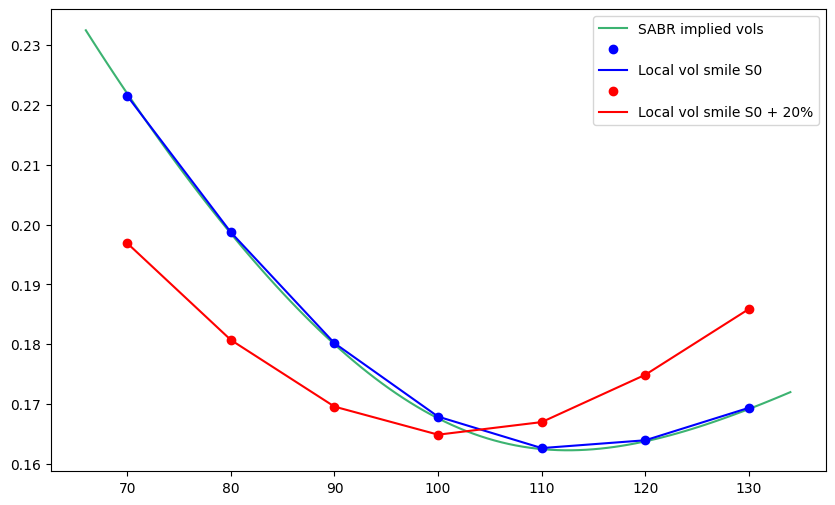

In [ ]:
from scipy import optimize

# vol implicite en 3 lignes de code : merci Python !
def bs_implied_vol(T, K, F0, call_price):
  def target(vol):
    return bs_call(T, K, F0, vol) - call_price
  return optimize.newton(target, 0.2)

strikes = range(70, 140, 10) # => strikes = [70, 80, ..., 130]

shift_factor = 1.2 #S0 => S0+20%
impvols = []
shifted_impvols = []

for strike in strikes:
  def call_payoff(t, v):
    if (math.isclose(t,T)):
      v = np.maximum(pde.s - strike, 0)
    return v
  print("pricing calls @ strike {}...".format(strike))
  v = pde.compute_price(call_payoff, display=False, return_price_grid=True)
  price_interp = interp1d(pde.s, v[0,:], kind='linear')
  price = price_interp(S0)
  shifted_price = price_interp(S0*shift_factor)
  impvols.append(bs_implied_vol(T, strike, fwd, price/DF(T)))
  shifted_impvols.append(bs_implied_vol(T, strike, fwd*shift_factor, shifted_price/DF(T)))

print("\n--------\n")

# SABR vols
sabr_strikes = np.linspace(66, 134, 101, endpoint=True)
sabr_impvols = sabr_vol (T, sabr_strikes, fwd, 0.165, 0.6, -0.3, 1)

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,6)
plt.plot(sabr_strikes, sabr_impvols, color="mediumseagreen")
plt.plot(strikes, impvols, 'o', strikes, impvols, color='blue')
plt.plot(strikes, shifted_impvols, 'o', strikes, shifted_impvols, color='red')
plt.legend(["SABR implied vols",'', 'Local vol smile S0', '', 'Local vol smile S0 + 20%'])
plt.show()


## La dynamique du smile sous SABR est bien meilleure !

A contrario, la dynamique de smile obtenu dans le modèle SABR est beaucoup plus réaliste.

On représente ci-dessous le mouvement du smile SABR pris en input pour la maturité 1 an (`sigma0=0.165`, `alpha=0.6`, `rho=-0.3`, `beta=1`) lors du même mouvement de l'actif (hausse de 20%).

Comme attendu, le smile se déplace de façon beaucoup plus réaliste, en suivant le mouvement de hausse de l'actif. Le paramètres $\beta$ (exposant CEV) étant égal à 1, le modèle SABR est ici lognormal à volatilité stochastique, si bien que la vol ATM se conserve lors du mouvement de l'actif.

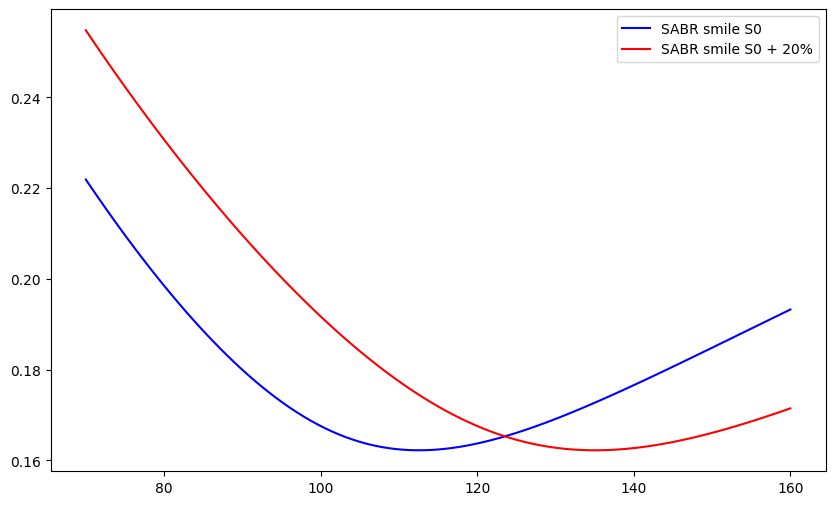

In [ ]:
strikes = np.linspace(70, 160, 101, endpoint=True)
impvols = sabr_vol (T, strikes, fwd, 0.165, 0.6, -0.3, 1)
shifted_impvols = sabr_vol (T, strikes, fwd*1.2, 0.165, 0.6, -0.3, 1)

plt.plot(strikes, impvols, color='blue')
plt.plot(strikes, shifted_impvols, color='red')
plt.legend(['SABR smile S0', 'SABR smile S0 + 20%'])
plt.show()



En réalité, sur les actions, on observe souvent une corrélation négative entre le niveau général de volatilité (et en particulier la vol ATM) et le niveau de l'actif : quand l'actif baisse la vol a tendance a augmenter, et inversement. Cela peut être obtenu dans le modèle SABR avec un paramètre $\beta$ inférieur à 1. Voici un exemple ci-dessous avec $\beta = 0.5$ (CIR à vol stochastique), où on obtient donc une vol ATM qui a tendance à baisser à mesure que l'actif augmente...

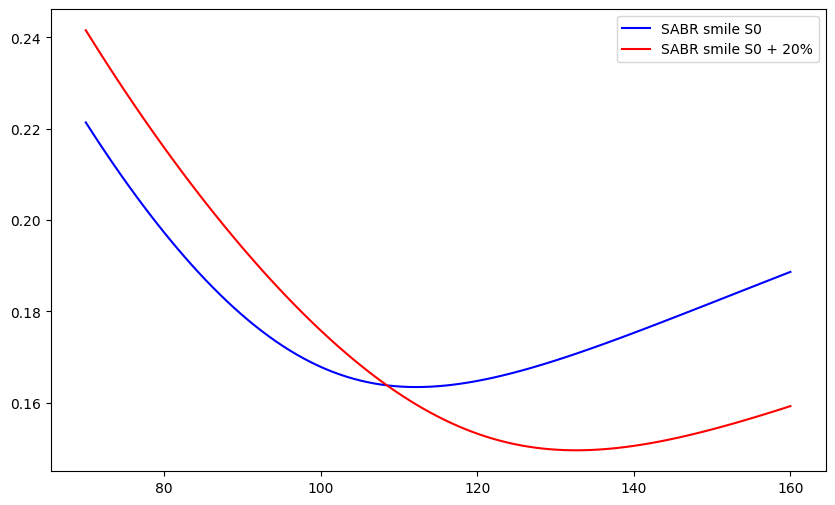

In [ ]:
# params SABR  1.639, 0.5568, -0.1341, 0.5 calibrés sur le smile SABR 0.165, 0.6, -0.3, 1 sur lequel est calibré le modèle à vol locale
strikes = np.linspace(70, 160, 101, endpoint=True)
impvols = sabr_vol (T, strikes, fwd, 1.639, 0.5568, -0.1341, 0.5)
shifted_impvols = sabr_vol (T, strikes, fwd*1.2, 1.639, 0.5568, -0.1341, 0.5)

plt.plot(strikes, impvols, color='blue')
plt.plot(strikes, shifted_impvols, color='red')
plt.legend(['SABR smile S0', 'SABR smile S0 + 20%'])
plt.show()

## Impact sur le delta

Bien sûr ces différentes approches on un impact sur la valeur des sensibilités. Même le delta d'un call européen ATM est impacté !

Essayer de d'expliquer les différences obtenues d'une méthode à l'autre ci-dessous...

In [ ]:
# calcul du delta du call ATM
v = pde.compute_price(european_call_payoff, display=False, return_price_grid=True)
price_interp = interp1d(pde.s, v[0,:], kind='linear')

# delta vol locale
# attention : il ne faut pas le calculer comme ça, justement à cause de la dynamique bizarre du smile
# bonne méthode : shifter S0, RECALCULER LES FORWARDS, LA NAPPE SABR ET LA VOL LOCALE,
# puis calculer un prix shifté avec la nouvelle vol locale, et calculer le delta par différence entre ces deux prix....
delta_vol_locale = (price_interp(S0+0.0001) - price_interp(S0-0.0001)) / 0.0002
print("Delta VL (bad) = {:.3f}".format(delta_vol_locale))

# delta BS
delta_bs =  DF(T) * (bs_call(T, K, fwd*1.0001, vol) - bs_call(T, K, fwd*0.9999, vol)) /(0.0002*S0)
print("Delta BS = {:.3f}".format(delta_bs))

# delta SABR 1 (sur lequel on a calibré la vol locale)
delta_sabr_1 =  DF(T) * (bs_call(T, K, fwd*1.0001, sabr_vol (T, K, fwd*1.0001, 0.165, 0.6, -0.3, 1)) - bs_call(T, K, fwd*0.9999, sabr_vol (T, K, fwd*0.9999, 0.165, 0.6, -0.3, 1))) /(0.0002*S0)
print("Delta SABR = {:.3f}".format(delta_sabr_1))

# delta SABR 2 (beta = 0.5, calibré sur le smile SABR ci-dessus)
delta_sabr_2 =  DF(T) * (bs_call(T, K, fwd*1.0001, sabr_vol (T, K, fwd*1.0001, 1.639, 0.5568, -0.1341, 0.5)) - bs_call(T, K, fwd*0.9999, sabr_vol (T, K, fwd*0.9999, 1.639, 0.5568, -0.1341, 0.5))) /(0.0002*S0)
print("Delta SABR 0.5 beta = {:.3f}".format(delta_sabr_2))



Delta VL (bad) = 0.480
Delta BS = 0.521
Delta SABR = 0.556
Delta SABR 0.5 beta = 0.518
